# How to Scale your Model

Link: https://jax-ml.github.io/scaling-book/

### Types of time

There are two types of time

- **computation time** - how much time accelerator spends on compute

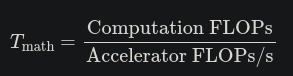

Computation FLOPs - how many FLOPs is needed to perform computation

Accelerator FLOPs/s - how many FLOPs accelerator can perform in one second

- **communication time** - how much time accelerator spends on sending/receiving data

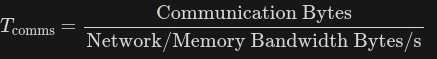

Communication Bytes - how many bytes is needed to read/write/send to another block inside accelerator or send to another accelerator

Network/Memory Bandwidth - it is what it is

### Upper and Lower bounds

Typically (but not always), computation within a single chip can be overlapped with communication within a chip and between chips. This means we can lower-bound training and inference time by using the maximum of computation and communication time. The upper bound is sum of these two times:

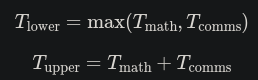

Usually we use optimize against the maximum as the algebra is simpler and we can usually come close to this bound by overlapping our communication and computation.

### Compute and communication bound

T<sub>math</sub> > T<sub>comms</sub> - full utilization from our hardware, we that this operation is **“compute-bound”** and this is desired situation

T<sub>math</sub> < T<sub>comms</sub> - underutilization because some fraction of our accelerator FLOPs/s is wasted waiting for data to be passed around, operation is **“communication-bound"**

### Arithmetic Intensity

 One way to tell if an operation will be compute or communication-bound is to look at its “arithmetic intensity” or “operational intensity”.

 **Definition**: the arithmetic intensity of an algorithm is given by the ratio of the total FLOPs it performs to the number of bytes it needs to communicate — either within a chip or between chips.

 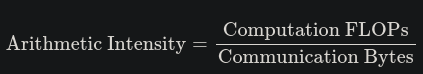

Accelerator has its own arithmetic intensity too and we can derive the relation between this intensities from relation between times:

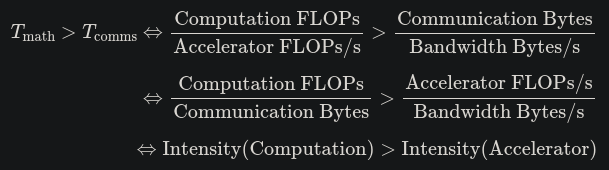

So, if we want our accelerator to be fully utilized by computing algorithm, we need intensity of this algorithm to be more than intensity of accelerator.


### Visualizing rooflines

We can visualize the tradeoff between memory and compute using a roofline plot, which plots the peak achievable FLOPs/s (throughput) of an algorithm on our hardware (the y-axis) against the arithmetic intensity of that algorithm (the x-axis). Here’s an example log-log plot:

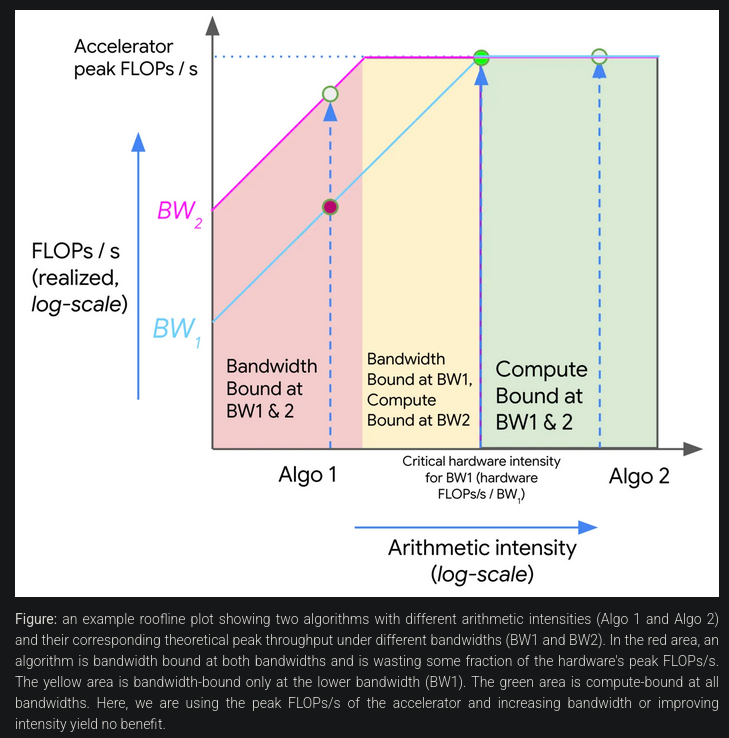

### Examples

1. Matrix multiplication, one TPU

X∗Y→Z where X has shape bf16[B,D]bf16[B,D] , Y has shape bf16[D,F]bf16[D,F] , and Z has shape bf16[B,F]bf16[B,F]

To do the matmul we need to load 2DF+2BD bytes, perform 2BDF FLOPs, and write 2BF bytes back.

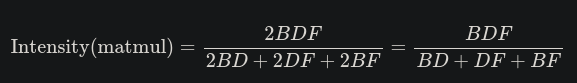

Assume that B (batch size) << D and F, then, assuming that our TPU has 1.97e14 compute power and 8.2e11 bandwidth:

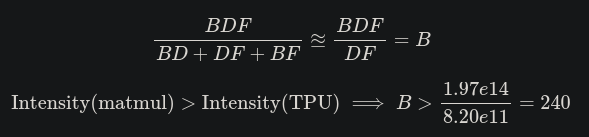

This is a reasonable assumption for Transformer matmuls since we typically have a local (per-replica) batch size B < 1024 tokens (not sequences) but D and F > 8000. Thus we generally become compute-bound when our per-replica batch size is greater than 240 tokens.

2. Matrix multiplication, two TPUs

Then we split half matrices X and Y by axis D:

A = X[:, :D // 2] @ Y[:D // 2, :] on TPU 0 and B = X[:, D // 2:] @ Y[D // 2:, :] on TPU 1

Then Z = A + B, but we won't consider final addition in our calculation.

T<sub>math</sub>​ is clearly half of what it was before, since each TPU is doing half the work, i.e.:

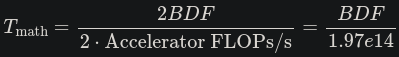

Now what about Tc<sub>comms</sub>? This now refers to the communication time between chips. This is just the total bytes sent divided by the network bandwidth, i.e.:

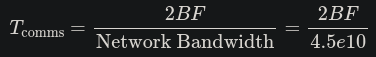

Then matmul intensity = BDF / 2 BF = D / 2 => to become compute bound we need D / 2 > 1.97e14/4.5e10 = 4377 => D > 8755.

Note that, unlike before, the critical threshhold now depends on D and not B.

## Sharding

### Sharding notation

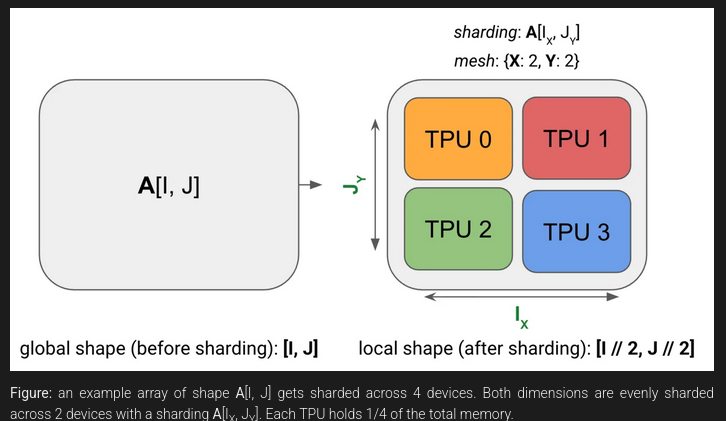

 - Mesh - shape of array of devices, example: grid 2 x 2 -> Mesh(devices=((0, 1), (2, 3)), axis_names=(‘X', ‘Y'))
 - Sharding: data array A[ I<sub>X</sub>, J<sub>Y</sub> ], which tells us to shard the first axis, I, along the mesh axis X, and the second axis, J, along the mesh axis Y. This sharding tells us that each shard holds 1/(∣X∣⋅∣Y∣) of the array. Sharding axis and mesh axis are independent, e.g. axis I can be sharded along both X and Y axis and sharding notation will be this: A[I<sub>XY</sub>​,J].
 
 Here's all possible shardings for 2D mesh of 4x4 devices and 2D data array:
 
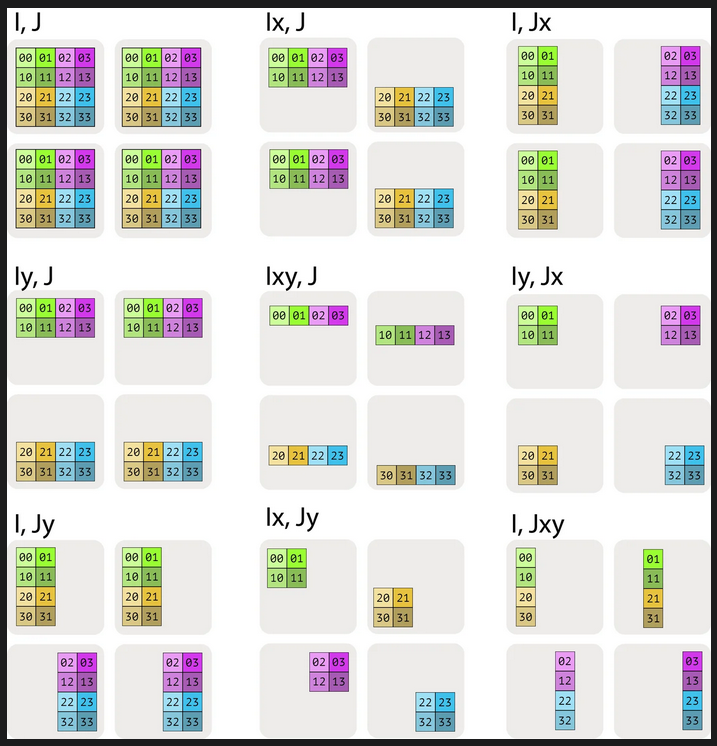
 
 I<sub>XY</sub> and I<sub>YX</sub> are different shardings
 
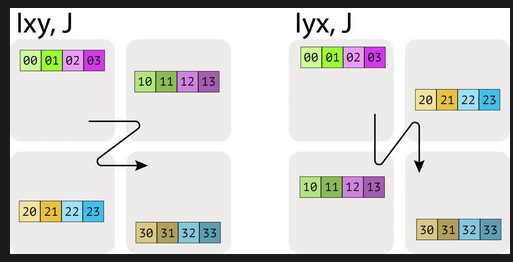
  
  ### Types of communication primitives that are used in sharding
  
  1. **AllGather** - removes the sharding along an axis and reassembles the shards spread across devices onto each device along that axis. Using the notation above, an AllGather removes a subscript from a set of axes, e.g.:
  
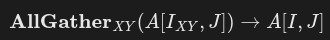
  
  **AllGather visualization**

In [5]:
from IPython.display import HTML

# Embed GIF using HTML
HTML('<img src="https://jax-ml.github.io/scaling-book/assets/img/all-gather.gif" width="450" height="250"/>')

  AllGather computation time. Let V be the number of bytes in the array, and X be the number of shards on the contracting dimension. Then from the above diagram, each hop sends V/∣X∣ bytes in each direction, so each hop takes
  
  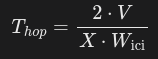
  
  where W<sub>ici</sub> is the bidirectional ICI (Inter Chip Connection) bandwidth. We need to send a total of ∣X∣/2∣ hops to reach every TPU, so the total reduction takes
  
  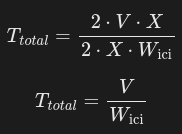
  
  Note that AllGather time doesn’t depend on X!
  
  Here is an empirical measurement of AllGather bandwidth on a TPU v5e 8x16 slice. The array is sharded across the second (16) axis so it has a full bidirectional ring.
  
  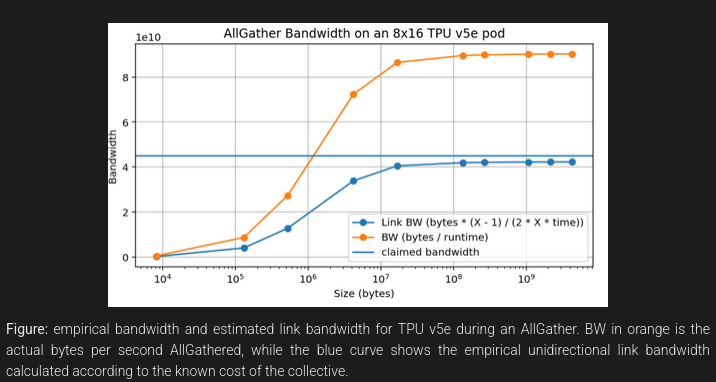
  
  What happens when we AllGather over multiple axes? When we gather over multiple axes, we have multiple dimensions of ICI over which to perform the gather. For instance, 
  AllGather<sub>XY</sub>([B, D<sub>XY</sub>]) operates over two hardware mesh axes. This increases the available bandwidth by a factor of N<sub>axes</sub>.

  When considering latency, we end up with the general rule:
  
  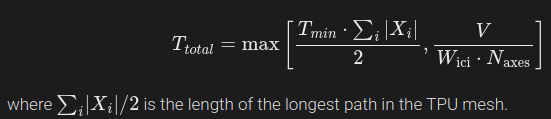
  
  2. **ReduceScatter** - removes a subscript ( F<sub>Y</sub>→F above), a ReduceScatter sums an unreduced/partially summed array and then scatters (shards) a different logical axis along the same mesh axis. [F]{U<sub>Y</sub>}→[F<sub>Y</sub>​]. The animation shows how this is done: note that it’s very similar to an AllGather but instead of retaining each shard, we sum them together. Thus, its latency is roughly the same, excluding the time taken to perform the reduction.
  
  **ReduceScatter visualization**

In [6]:
from IPython.display import HTML

# Embed GIF using HTML
HTML('<img src="https://jax-ml.github.io/scaling-book/assets/img/reduce-scatter.gif" width="450" height="250"/>')

  ReduceScatter is an opposite operation to AllGather. Likewise,  in the forward pass implies 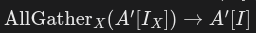 in the backwards pass.
  
  ReduceScatter computation time. The communication time for each hop is simply the per-shard bytes V/Y divided by the bandwidth W<sub>ici</sub>, as it was for an AllGather, so we have:
  
  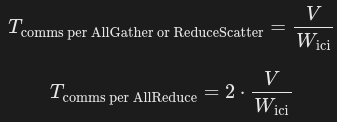
  
  3. **AllReduce** - removes partial sums, resulting in each device along the axis having the same fully-summed value. AllReduce takes an array with an unreduced (partially summed) axis and performs the sum by passing those shards around the unreduced axis and accumulating the result. The signature is:
  
  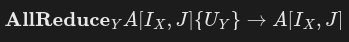

  AllReduce computation time. One mental model for how an AllReduce is performed is that every device sends its shard to its neighbors, and sums up all the shards that it receives. Clearly, this is more expensive than an AllGather because each “shard” has the same shape as the full array. Generally, an AllReduce is twice as expensive as an AllGather. One way to see this is to note that an AllReduce can be expressed as a composition of two other primitives: a ReduceScatter and an AllGather.
  
  4. **AllToAll** - the special case of a sharded transposition or resharding operation. e.g.
  
  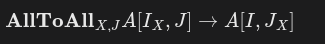
  
  AllToAlls are typically required to rearrange sharded layouts between different regions of a sharded computation that don’t have compatible layout schemes. They arise naturally when considering sharded mixture-of-experts models. You can think of an AllToAll as moving a subscript from one axis to another.
  
  **AllToAll visualization**

In [10]:
from IPython.display import HTML

# Embed GIF using HTML
HTML('<img src="https://jax-ml.github.io/scaling-book/assets/img/all-to-all.gif" width="750" height="250"/>')

  AllToAll computation time. Because an all to all doesn’t need to replicate all of the data of each shard across the ring, it’s actually cheaper than an AllGather (by a factor of ¼).
  
  Explanation:
  
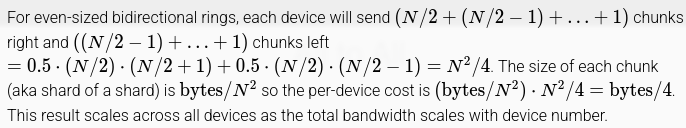
  
  ### Computation With Sharded Arrays
  
 The most common operation in machine learning is matrix multiplication
 
 There are 4 cases of sharded matrices multiplication
 
 1. **Case 1**: neither input is sharded along the contracting dimension. We can multiply local shards without any communication.
 
  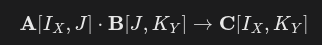
 
 2. Case 2: one input has a sharded contracting dimension. We typically “AllGather” the sharded input along the contracting dimension, because we can't multiply matrices when we have two different contracting dimensions.
 
  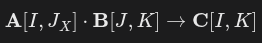
 
 3. Case 3: both inputs are sharded along the contracting dimension. We can multiply the local shards, then “AllReduce” the result.
 
  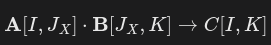
 
 4. Case 4: both inputs have a non-contracting dimension sharded along the same axis. We cannot proceed without AllGathering one of the two inputs first.
 
  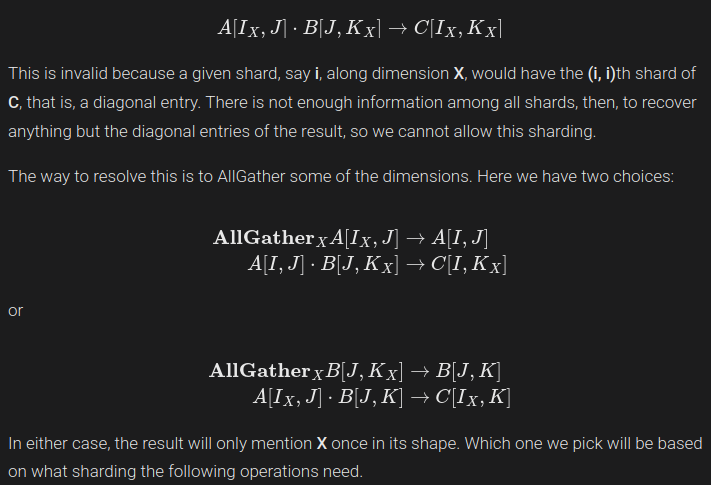

# Transformers

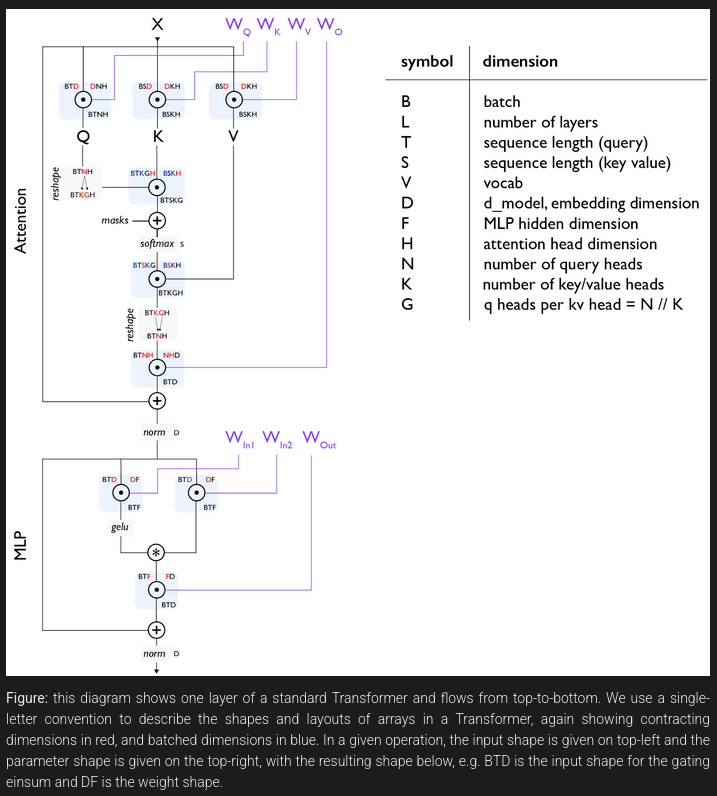

## Matmul forward and backward FLOPs calculation

Let’s start with vectors x,y and matrices A,B of the following shapes:

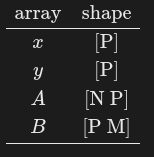

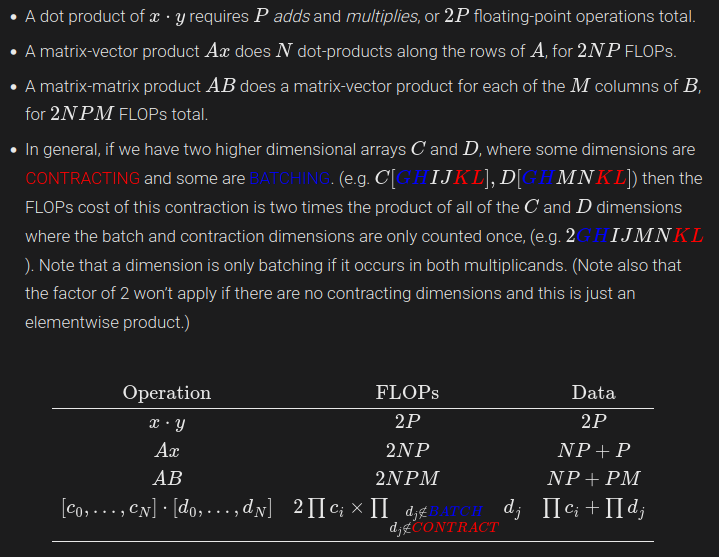

In [4]:
from IPython.display import HTML

# Embed GIF using HTML
HTML('<img src="https://jax-ml.github.io/scaling-book/assets/img/matmul-flops.gif" width="600" height="300"/>')

During forward path we have 2NPM flops. During backward path we have to calculate gradient for both matrices A and B:

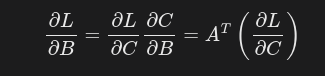

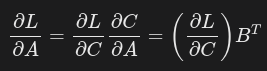

Where L - loss and C = A @ B.

Both of these operations take 2NPM FLOPs too since dL/dB and dL/dC have shapes [N, M] and contracting dimensions are N and M respectively.

Adding these up, we see that **during training, we have a total of 6NPM FLOPs**, compared to 2NPM during inference: 2NPM in the forward pass, 4NPM in the backward pass. 

Since PM is the number of parameters in the matrix, this is the simplest form of the famous 6 \* num parameters \* num tokens. Each token resquires 6 \* num parameters FLOPs.

## Transformer FLOPs and Params Calculation

### MLP

The MLPs of a Transformer typically consist of 2 input matmuls that are element-wise combined and a single output matmul:

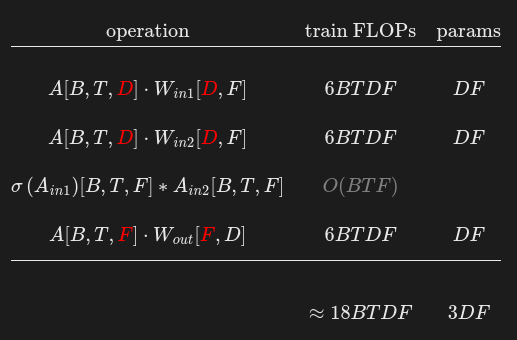

### Attention

Estimated cost of the QKVO matmuls:

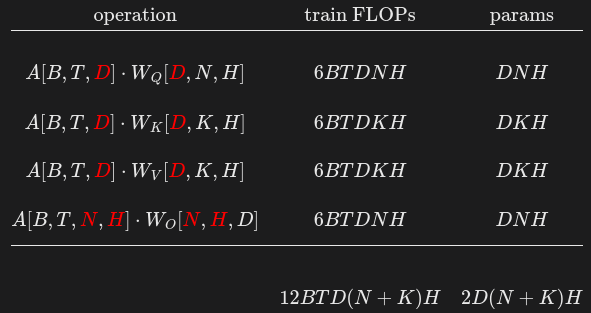

Estimated cost of the dot-product attention:

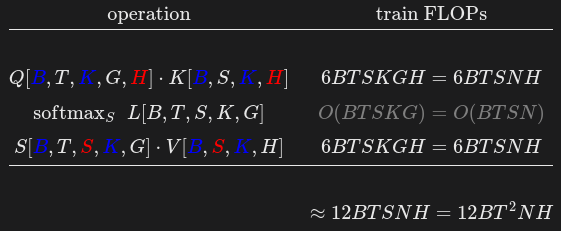

### Other operations (layer norm and vocab)

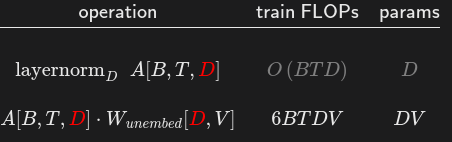

Total vocab train FLOPs are 12BTDV

### General rule of thumb for Transformer FLOPs

If we neglect the cost of dot-product attention for shorter-context training, then the total FLOPs across all layers is:

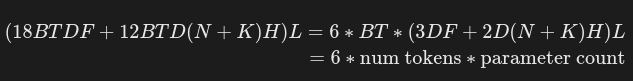

### Fractional cost of attention with context length

If we do account for dot-product attention above and assume F = 4D, D = NH and N = K:

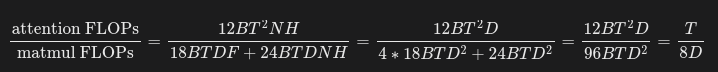

So the takeaway is that dot-product attention FLOPs only become dominant during training once T>8D. 

For D ~ 8k, this would be ~64K tokens. This makes some sense, since it means as the MLP size increases, the attention FLOPs become less critical. 

For large models, the quadratic cost of attention is not actually a huge obstacle to longer context training. 

However, for smaller models, even e.g. Gemma-27B, D=4608 which means attention becomes dominant around 32k sequence lengths. 

Flash Attention also helps alleviate the cost of long-context.

## Key-Value (KV) caching

Each KV cache is then effectively an array of size [2,S,L,K,H]. This is quite large! 

The total size of the Key-Value cache in int8 is 2SLKH. 

For a moderately-sized model with 8k context length, 64 layers, and KH=NH=D=8192, this is 2⋅8192⋅64⋅8192=8GiB. 

You can see why we would want to use Groupped Query Attention with K≪N.

# How to Parallelize a Transformer for Training

We’ll use the following notation to simplify calculations throughout this section.

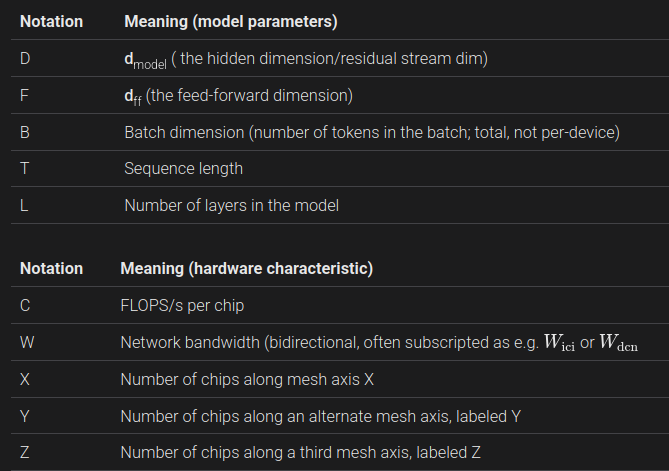

For simplicity’s sake, we’ll approximate a Transformer as a stack of MLP blocks — attention is a comparatively small fraction of the FLOPs for larger models

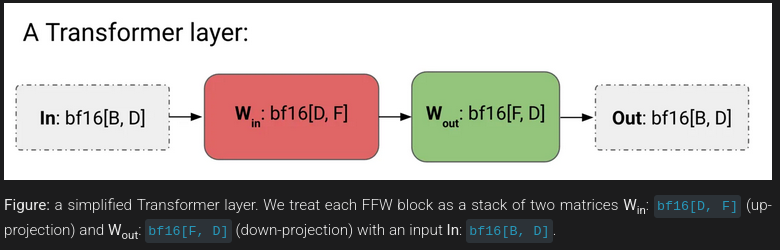

Here’s the full algorithm for our little Transformer with no parallelism.

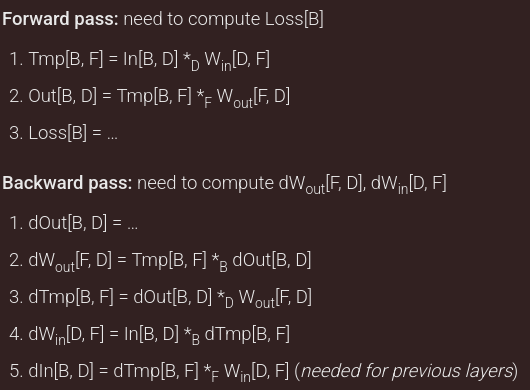

## Parallelism schemes

### Data parallelism

Activations sharded along batch, parameters and optimizer state are replicated on each device. Communication only occurs during the backwards pass.

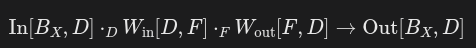

When your model fits on a single chip with even a tiny batch size (>240 tokens, so as to be compute-bound), **you should always use simple data parallelism**.

Pure data parallelism splits our activations across any number of TPUs so long as the number of TPUs is smaller than our batch size. 

 The forward pass involves no communication, but at the end of every step, **each TPU performs an AllReduce on its local gradients to synchronize them before updating the parameters.**

 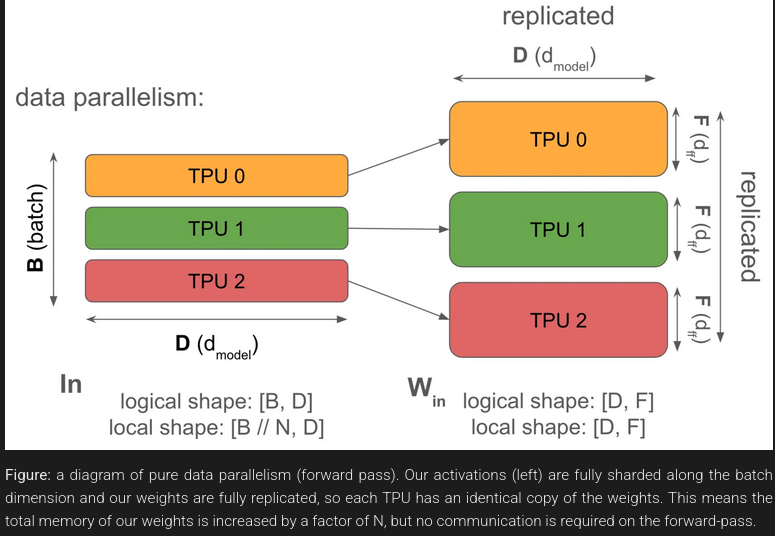

 Here’s the full algorithm for the forward and backwards pass. We abuse notation to write dL/dOut as dOut, purely for compactness.

 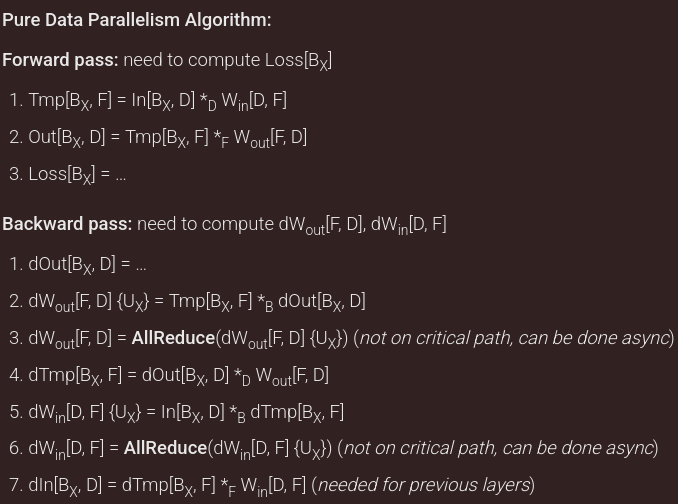

Note that the forward pass has no communication — it’s all in the backward pass! The backward pass also has the great property that the AllReduces aren’t in the “critical path”, meaning that each AllReduce can be performed whenever it’s convenient and doesn’t block you from performing subsequent operations. The overall communication cost can still bottleneck us if it exceeds our total compute cost, but it is much more forgiving from an implementation standpoint. We’ll see that model/tensor parallelism doesn’t have this property.

**Why do this?** Pure data parallelism reduces activation memory pressure by splitting our activations over the batch dimension, allowing us to almost arbitrarily increase batch size as long as we have more chips to split the batch dimension over. Especially during training when our activations often dominate our memory usage, this is very helpful.

Why not do this? Pure data parallelism does nothing to reduce memory pressure from model parameters or optimizer states, which means pure data parallelism is rarely useful for interesting models at scale where our parameters + optimizer state don’t fit in a single TPU. To give a sense of scale, if we train with parameters in bf16 and optimizer state in fp32 with Adam, the largest model we can fit has TPU memory / 10, so e.g. on a TPUv5p chip with 96GB of HBM and pure data parallelism this is about 9B parameters.

#### When do we become bottlenecked by communication?

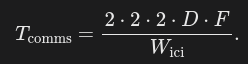

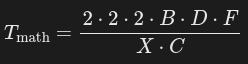

Total time:

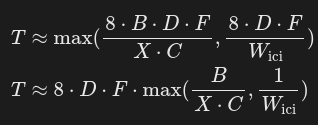

We become compute-bound when T_math > T_comms, or when

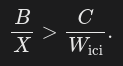

The upshot is that, to remain compute-bound with data parallelism, we need the per-device batch size B / X to exceed the ICI operational intensity, C / W_ici.

For example, for TPUv5p, C=4.6e14, W_ici=2 * 9e10 for 1D data parallelism our batch size per chip **must be at least 2,550 to avoid being communication-bound**.

Since we can do data parallelism over multiple axes, if we dedicate all three axes of a TPUv5p pod to pure data parallelism, we 3x our bandwidth W_ici and can scale down to only BS=850 per TPU or 7.6M tokens per batch per pod (of 8960 chips). **This tells us that it’s fairly hard to become bottlenecked by pure data parallelism!**

### Fully-Sharded Data Parallelism (FSDP)

Fully-sharded data parallelism (often called FSDP or ZeRO-sharding because of related work: "ZeRO: Memory optimizations toward training Trillion parameter models")
splits the model optimizer states and weights across the data parallel shards and efficiently gathers and scatters them as needed. **Compared to pure data parallelism, FSDP drastically reduces per-device memory usage and saves on backward pass FLOPs, with very minimal overhead.**

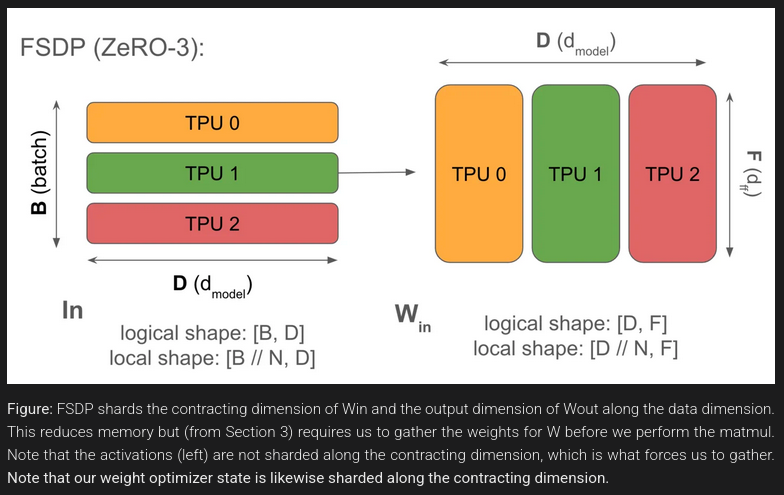

Here’s the full algorithm for FSDP:

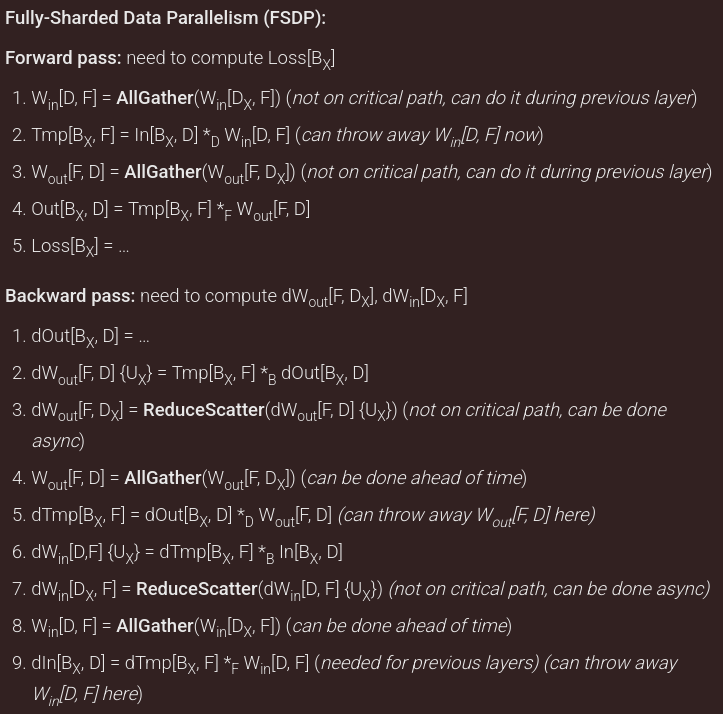

This is also called “ZeRO Sharding”, from “ZeRo Overhead sharding” since we don’t perform any unnecessary compute or store any unnecessary state. ZeRO-{1,2,3} are used to refer to sharding the optimizer states, gradients, and weights in this way, respectively. Since all have the same communication cost, we can basically always do ZeRO-3 sharding, which shards the parameters, gradients, and optimizer states across a set of devices.

**Why do this?** Standard data parallelism involves a lot of duplicated work. Each TPU AllReduces the full gradient, then updates the full optimizer state (identical work on all TPUs), then updates the parameters (again, fully duplicated). For ZeRO sharding (sharding the gradients/optimizer state), instead of an AllReduce, you can ReduceScatter the gradients, update only your shard of the optimizer state, update a shard of the parameters, then AllGather the parameters as needed for your forward pass.

**When do we become bottlenecked by communication?** Our relative FLOPs and comms costs are exactly the same as pure data parallelism, since each AllReduce in the backward pass has become an AllGather + ReduceScatter.

Here we model the forward pass since it has the same FLOPs-to-comms ratio as the backward pass:

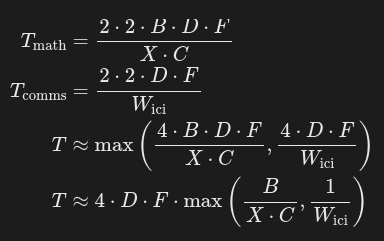

Therefore, as with pure data-parallelism, we are compute bound when

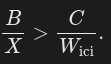

 i.e. when the per-device batch size B / X exceeds the “ICI operational intensity” C / W_ici (~ 2550 for TPUv5p).

 This is great for us, because it means if our per-device batch size is big enough to be compute-bound for pure data-parallelism, we can — without worrying about leaving the compute-bound regime — simply upgrade to FSDP, saving ourselves a massive amount of parameter and optimizer state memory.

 Though we did have to add communication to the forward pass, this cost is immaterial since it just overlaps with forward-pass FLOPs.

### Tensor Parallelism

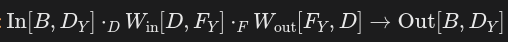

In a fully-sharded data-parallel AllReduce we move the weights across chips. We can also shard the feedforward dimension (D) of the model and move the activations during the layer — this is called “1D model parallelism” or Megatron sharding (Megatron-LM: Training multi-billion parameter language models using model parallelism)
This can unlock a smaller efficient batch size per pod. The figure below shows an example of a single matrix sharded in this way:

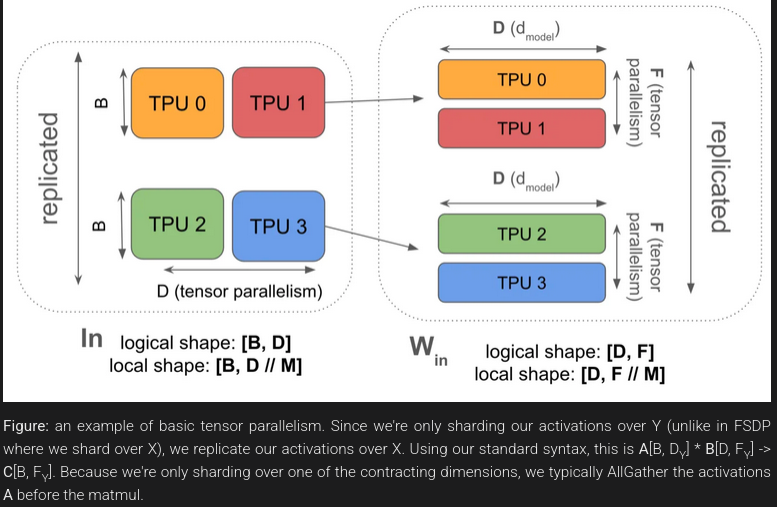

Here’s the algorithm for tensor parallelism:

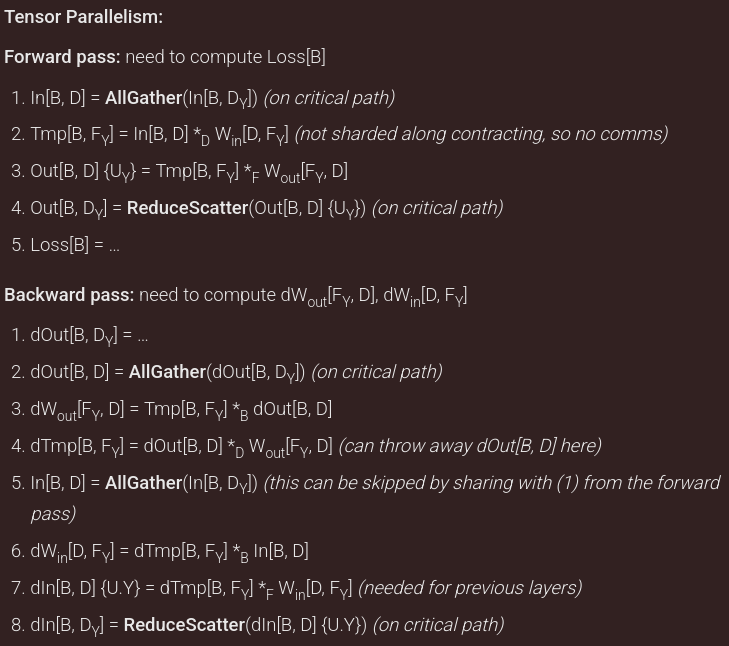

**How costly is this?** Let’s only model the forward pass - the backwards pass is just the transpose of each operation here. In 1D tensor parallelism we AllGather the activations before the first matmul, and ReduceScatter them after the second, sending two bytes at a time (bf16). Let’s figure out when we’re bottlenecked by communication.

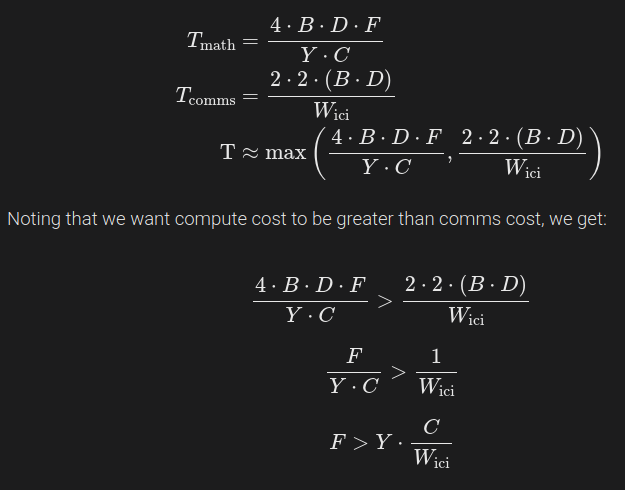

Thus for instance, for TPUv5p, C/W_ici = 2550 in bf16, so we can only do tensor parallelism up to Y < F/2550.

When we have multiple ICI axes, our T_comms is reduced by a factor of M_y, so we are compute bound until Y < M_y * F / 2550.

For most models this is between 8 and 16-way tensor parallelism.

### FSDP + Tensor Parallelism

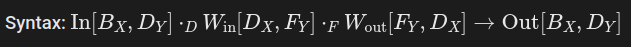

By sharding W_in and W_out along both axes we both save memory and compute. Because we shard B along X, we reduce the size of the model-parallel AllGathers, and because we shard F along Y, we reduce the communication overhead of FSDP. This means a combination of the two can get us to an even lower effective batch size than we saw above.

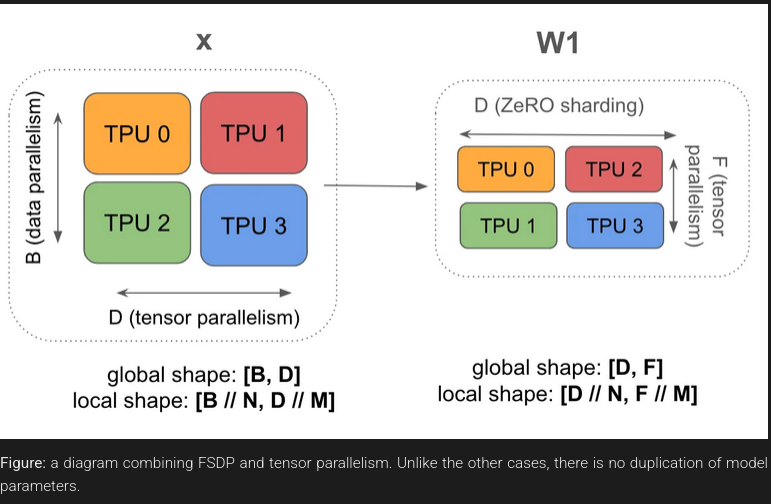

Here's the full algorithm of FSDP + Tensor Parallelism:

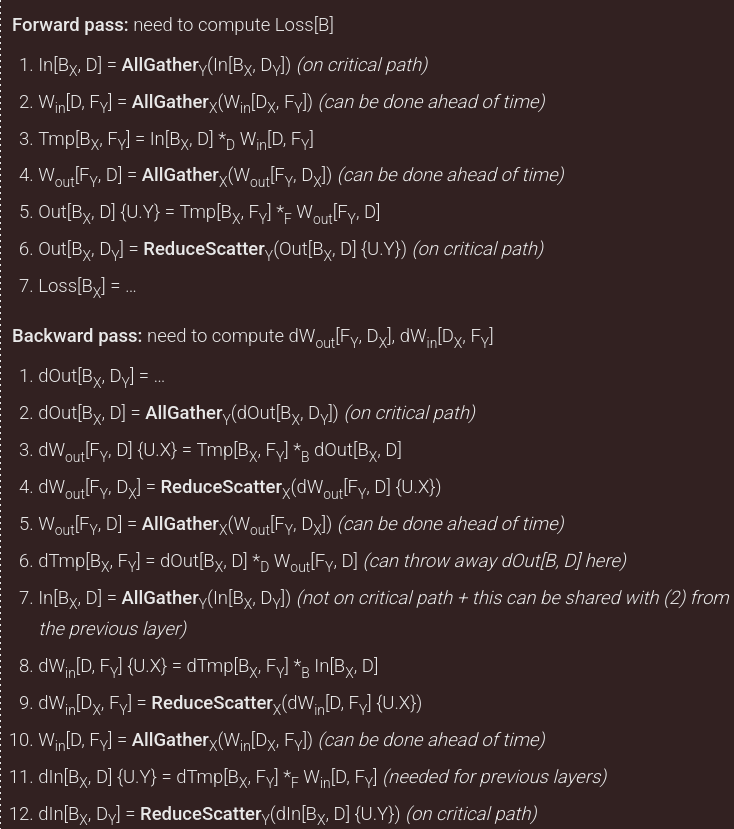

**What is right combination of FSDP and TP?**

Suppose X is number of FSDP shards, Y - number of TP shards. 

M_x - how many axis in slice (e.g. TPUv5p 16x16x16 slice with 3 axis) are used for FSDP, M_y - how many axis in slice are used for TP.

N = X * Y (e.g. total number of devices in slice)

Optimal amount of FSDP is:

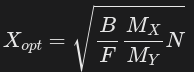

Plugging in realistic values, namely N=64 (corresponding to a 4x4x4 array of chips), B=48000 , F=32768, gives roughly X≈13.9. So we would choose X to be 16 and Y to be 4, close to our calculated optimum.

**Under what conditions will we be compute-bound?**

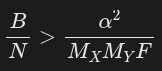

α - Arithmetic Intensity of device

To get approximate numbers, again plug in F=32768, α=2550, and M_x * M_y = 2 (as it must be for a 3D mesh). This gives roughly B / N > 99. To become compute bound we need a batch of as little as 100 per chip.

Below we plot the ratio of FLOPs to comms time for mixed FSDP + TP, comparing it both to only tensor parallelism (TP) and only data parallelism (FSDP), on a representative 4x4x4 chip array. While pure FSDP parallelism dominates for very large batch sizes, in the regime where batch size over number of chips is between roughly 100 and 850, a mixed FSDP + TP strategy is required in order to be compute-bound.

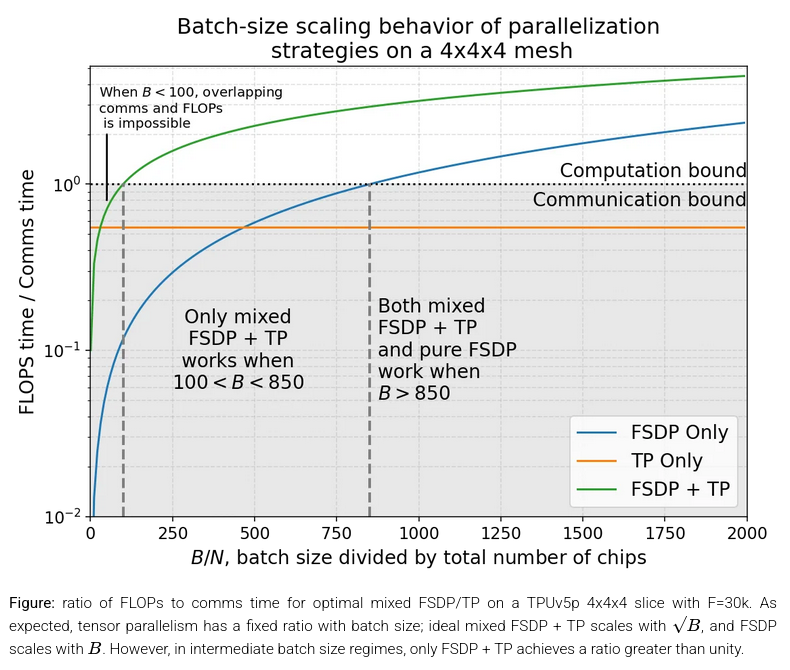

Here’s another example of TPU v5p 16x16x16 showing the FLOPs and comms time as a function of batch size for different sharding schemes.

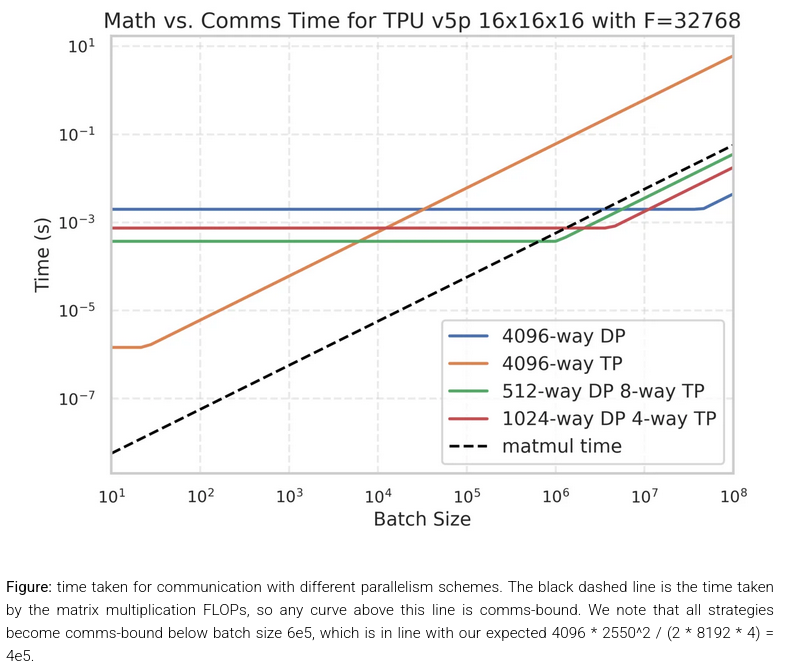

The black curve is the amount of time spent on model FLOPs, meaning any batch size where this is lower than all comms costs is strictly comms bound. You’ll notice the black curve intersects the green curve at about 4e5, as predicted.

### Pipelining

Pipelining is a dominant strategy for GPU parallelism that is somewhat less essential on TPUs. Briefly, pipelined training involves splitting the layers of a model across multiple devices and passing the activations between pipeline stages during the forward and backward pass. The algorithm is something like:

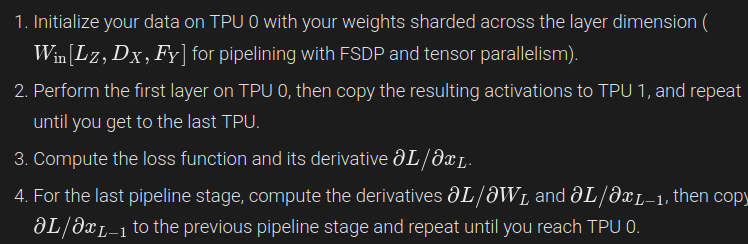

**Why is this a good idea?** Pipelining is great for many reasons: it has a low communication cost between pipeline stages, meaning you can train very large models even with low bandwidth interconnects. This is often very useful on GPUs since they are not densely connected by ICI in the way TPUs are.

**Why is this difficult/annoying?** First TPUs in pipe are almost always idle! They're only doing work on the very first and last step of the pipeline. The period of idleness is called a pipeline bubble and is very annoying to deal with. Typically we try to mitigate this first with microbatching, which sends multiple small batches through the pipeline, keeping first TPUs utilized for at least a larger fraction of the total step time.

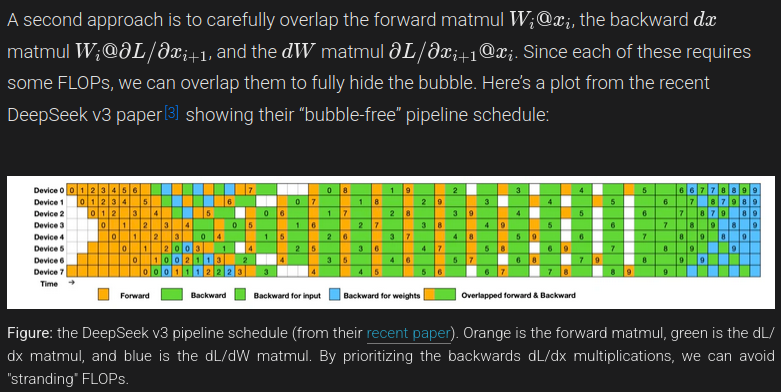

### Scaling Across Pods

The largest possible TPU slice is a TPU v5p SuperPod with 8960 chips (and 2240 hosts). When we want to scale beyond this size, we need to cross the Data-Center Networking (DCN) boundary. Each TPU host comes equipped with one or several NICs (Network Interface Cards) that connect the host to other TPU v5p pods over Ethernet. As noted in the TPU Section, each host has about 200Gbps (25GB/s) of full-duplex DCN bandwidth, which is about 6.25GB/s full-duplex (egress) bandwidth per TPU.

Typically, when scaling beyond a single pod, we do some form of model parallelism or FSDP within the ICI domain, and then pure data parallelism across multiple pods. Let NN be the number of TPUs we want to scale to and MM be the number of TPUs per ICI-connected slice. To do an AllReduce over DCN, we can do a ring-reduction over the set of pods, giving us (in the backward pass):

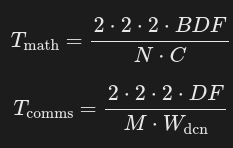

The comms bandwidth scales with MM , since unlike ICI the total bandwidth grows as we grow our ICI domain and acquire more NICs. Simplifying, we find that T_math>T_comms​ when

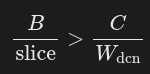

For TPU v5p C / W_dcn = 4.46e14 / 6.25e9 = 71360

This tells us that to efficiently scale over DCN, there is a minimum batch size per ICI domain needed to egress each node.

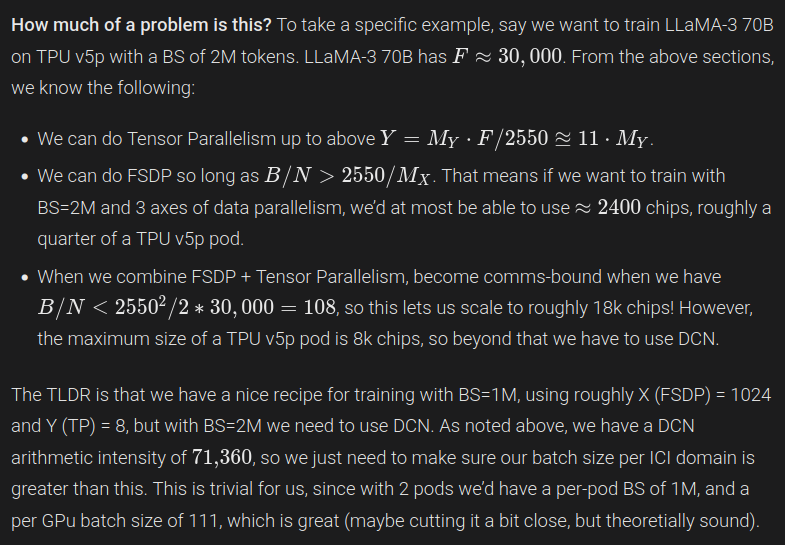

Why 18k chips? Because N = B / 108 = 2e6 / 108 ~ 18k

# Transformer Inference

During inference transformer works in two key modes:


- Prefill: Given a long prompt, we process all the tokens in the prompt at the same time and save the resulting activations (specifically, the key-value projections) in a “KV cache”. We also save the logits for the last token.

- Generation: Given a KV cache and the previous logits, we incrementally sample one token from the logits, feed that token back into the Transformer, and produce a new set of logits for the next step. We also append the KV activations for that new token to the KV cache. We repeat this until we hit a special \<EOS\> token or reach some maximum length limit.

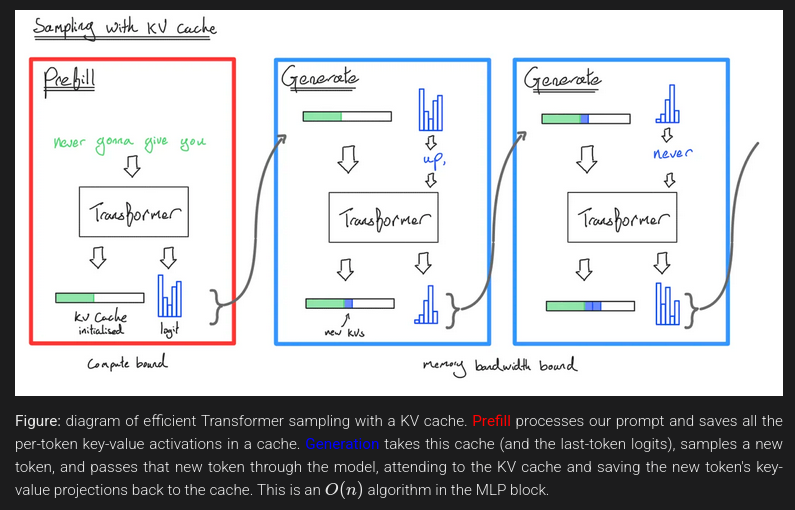

These modes are different: during prefill, attention is usually compute bound for any reasonable sequence length (roughly >480 tokens) while during generation our arithmetic intensity is low and constant (sequence length is always 1), so we are always memory bandwidth-bound.

## Theoretical estimates for LLM latency and throughput

For small batch sizes during generation (which is common), we can lower-bound our per-step latency by assuming we’re memory bandwidth bound in both the attention and MLP blocks:

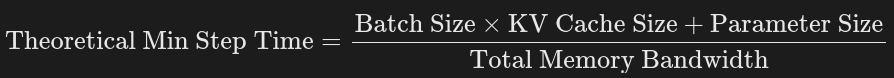

Similarly, for throughput:

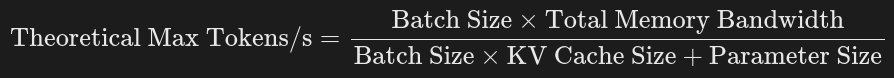

Eventually, as our batch size grows, FLOPs begin to dominate parameter loading, so in practice we have the more general equation:

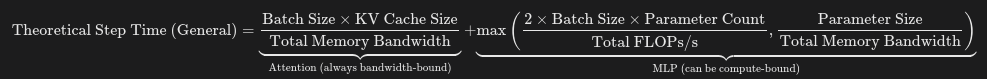

where the attention component (left) is never compute-bound, and thus doesn’t need a FLOPs roofline. 

As you can see, there’s a clear tradeoff between throughput and latency here. Small batches are fast but don’t utilize the hardware well. Big batches are slow but efficient. Here’s the latency-throughput Pareto frontier calculated for some older PaLM models:

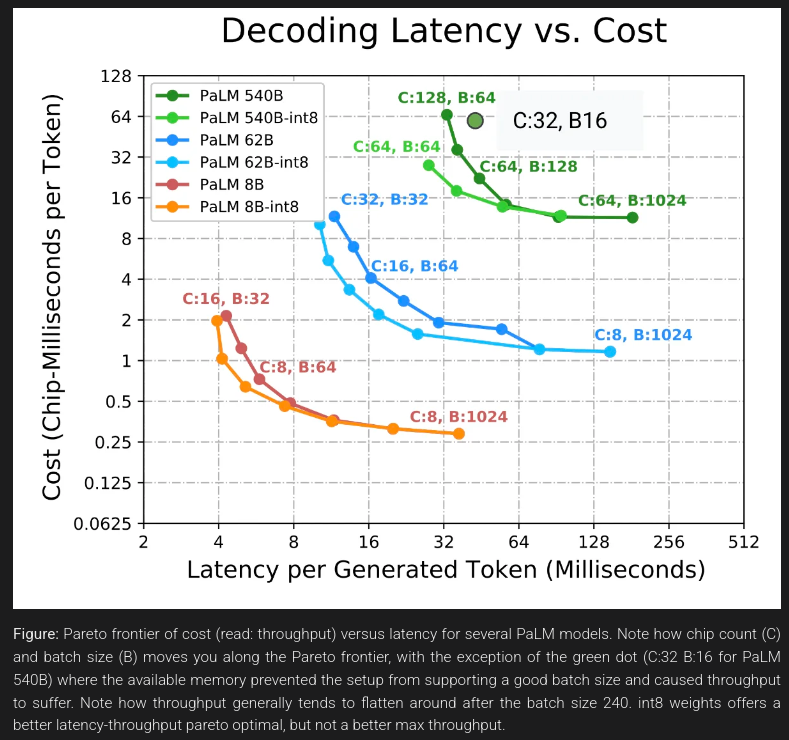

So, if you care about generation throughput, use the largest per-chip batch size possible. Any per-chip batch size above the TPU arithmetic intensity (B_crit​, usually 120 or 240) will maximize throughput. You may need to increase your topology to achieve this. Smaller batch sizes will allow you to improve latency at the cost of throughput.

## What about memory?

For this section, let’s pick a real model (LLaMA 2-13B) to demonstrate how different things look for inference:

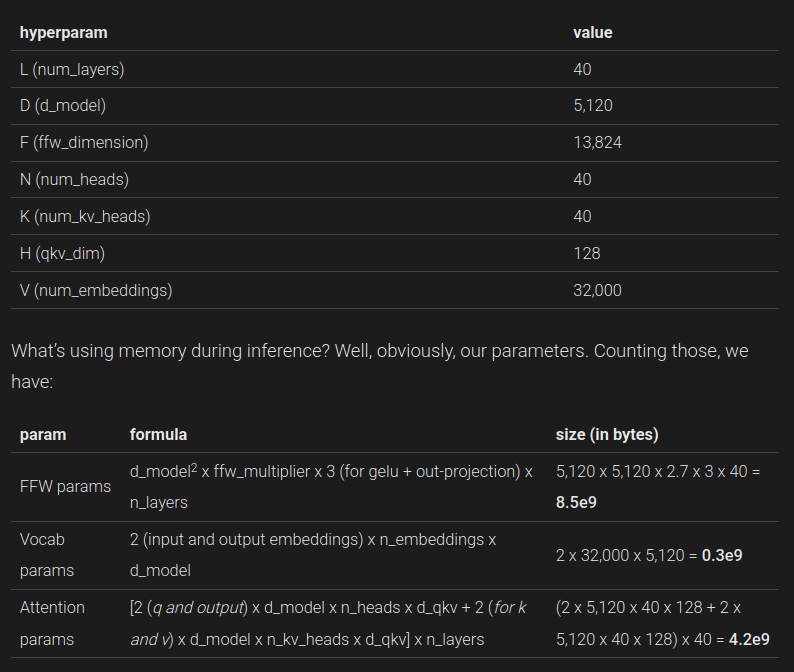

How is inference different? During inference, we store one copy of our parameters, let’s say in bfloat16. That uses 26GB — and in practice we can often do much better than this with quantization. There’s no optimizer state or gradients to keep track of. Because we don’t checkpoint (keep activations around for the backwards pass), our activation footprint is negligible for both prefill 4 and generate. If we prefill 8k tokens, a single activation only uses around 8192 \* 5120 \* 2 bytes = 80 MB. Longer prefills can be broken down into many smaller forward passes, so it’s not a problem for longer contexts either. Generation use even fewer tokens than that, so activations are negligible.

The main difference is the KV cache. These are the keys and value projections for all past tokens, bounded in size only by the maximum allowed sequence length. The total size for T tokens is:

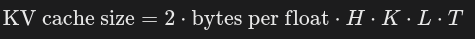



where H is the dimension of each head, K is the number of KV heads, L is the number of layers, and the 2 comes from storing both the keys and values.

**This can get big very quickly**, even with modest batch size and context lengths. For LLaMA-13B, a KV cache for a single 8192 sequence at bf16 is

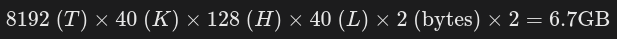

**Just 4 of these exceed the memory usage of our parameters! ** (TPUv5e has 16 GB memory)

## Tricks for Improving Generation Throughput and Latency

1. **Grouped multi-query attention (aka GMQA, GQA)**

We can reduce the number of KV heads, and share them with many Q heads in the attention mechanism. In the extreme case, it is possible to share a single KV head across all Q heads. This reduces the KV cache by a factor of the Q:KV ratio over pure MHA, and it has been observed that the performance of models is relatively insensitive to this change.

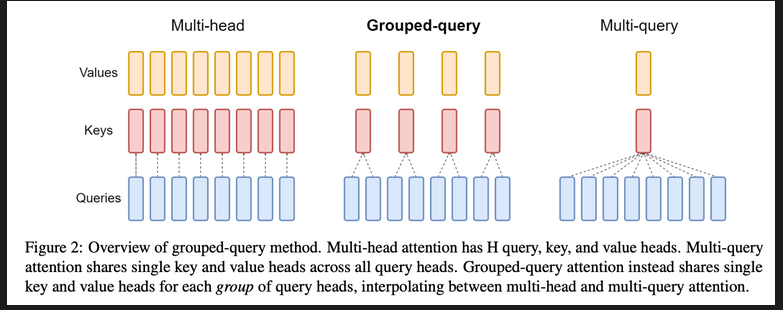

2. **Mixing in some local attention layers**

Local attention caps the context to a small to moderately sized max length. At training time and prefill time, this involves masking the attention matrix to a diagonal strip instead of a triangle. This effectively caps the size of the max length of the KV cache for the local layers. By mixing in some local layers into the model with some global layers, the KV cache is greatly reduced in size at contexts longer than the local window.

3. **Sharing KVs across layers** 

The model can learn to share the same KV caches across layers in some pattern. Whilst this does reduce the KV cache size, and provide benefits in increasing batch size, caching, offline storage etc. shared KV caches may need to be read from HBM multiple times, so it does not necessarily improve the step time.

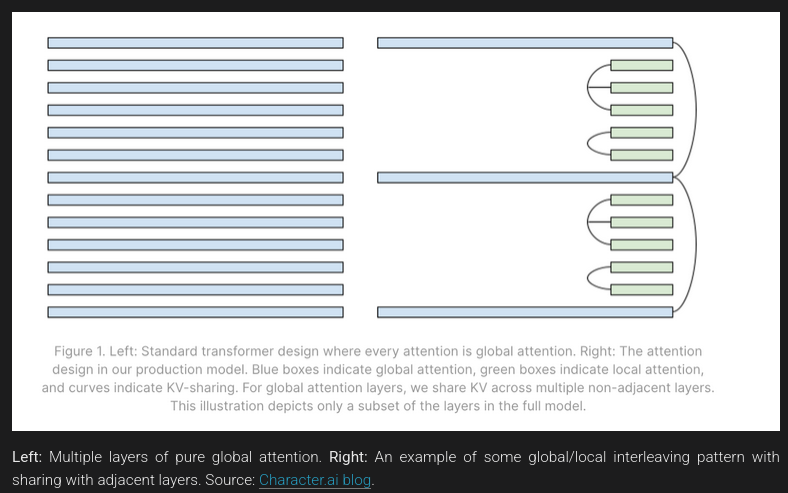

4. **Quantization**

Inference is usually less sensitive to the precision of parameters and KVs. By quantizing the parameters and KV cache (e.g. to int8, int4, fp8 etc.), we can save on memory bandwidth on both, decrease the batch size required to reach the compute roofline and save memory to run at bigger batch sizes. Quantization has the added advantage that even if the model was not trained with quantization it can often be applied post training.

5. **Using ragged HBM reads and Paged Attention**

We allocated 8k of context for each KV cache in the calculations above but it is often not necessary to read the entire KV cache from memory — requests have a wide range of length distributions and don’t use the max context of the model, so we can often implement kernels (e.g. Flash Attention variants) that only read the non-padding part of the KV cache.

Paged Attention is a refinement upon this that stores KV caches in OS-style page tables and mostly avoids padding the KV caches altogether. This adds a lot of complexity but means every batch only uses as much memory as it needs. This is a runtime optimization, so again it is indifferent to architecture.

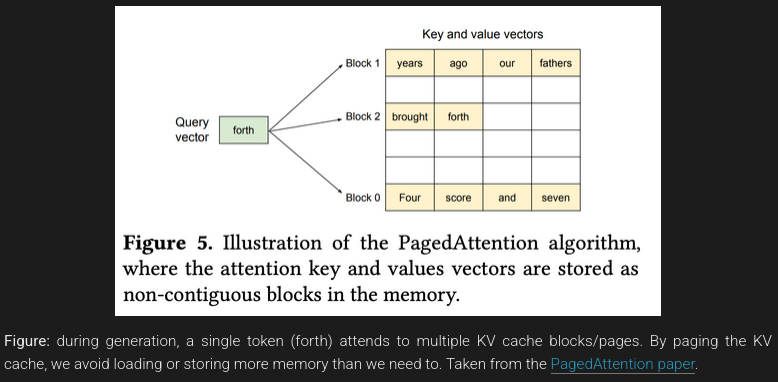

## Distributing Inference Over Multiple Accelerators

### Prefill

From a roofline standpoint, prefill is almost identical to training and almost all the same techniques and tradeoffs apply — model (Megatron) parallelism, sequence sharding (for sufficiently long context), pipelining, even FSDP are all viable! You just have to keep the KVs kicking around so you can do generation later. As in training, increasing the number of chips gives us access to more FLOPs/s (for potentially lower TTFT - Time to First Token), but adds communication overhead (potentially reducing throughput per chip).

So, during prefill, almost any sharding that can work during training can work fine. Do model parallelism up to the ICI bound, then do sequence parallelism.

### Generation

Generation is a more complicated beast than prefill. For one thing, it is harder to get a large batch size because we need to batch many requests together. Latency targets are lower. Together, these mean we are typically more memory-bound and more sensitive to communication overhead, which restrict our sharding strategies:

1. FSDP is impossible: since we are memory-bound in loading our parameters and KV caches from HBM to the MXU, we do not want to move them via ICI which is orders of magnitudes slower than HBM. We want to move activations rather than weights. This means methods similar to FSDP are usually completely unviable for generation.

2. There is no reason to do data parallelism: pure data parallelism is unhelpful because it replicates our parameters and doesn’t help us load parameters faster. You’re better off spinning up multiple copies of the model instead.

3. No sequence = no sequence sharding. Good luck sequence sharding.

This mostly leaves us with variants of model sharding for dense model generation. As with prefill, the simplest thing we can do is simple model parallelism (with activations fully replicated, weights fully sharded over hidden dimension for the MLP) up to 4-8 ways when we become ICI bound. However, since we are often memory bandwidth bound, we can actually go beyond this limit to improve latency! 

**Note on ICI bounds for generation**: during training we want to be compute-bound, so our rooflines look at when our ICI comms take longer than our FLOPs. However, during generation, if we’re memory bandwidth bound by parameter loading, we can increase model sharding beyond this point and improve latency at a minimal throughput cost. More model sharding gives us more HBM to load our weights over, and our FLOPs don’t matter. Let’s look at how much model parallelism we can do before it becomes the bottleneck.

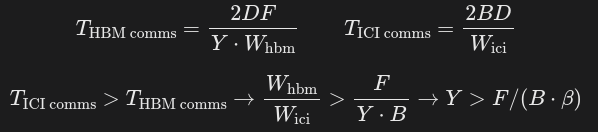

where beta = W_hbm / W_ici. This number is usually around 8 for TPU v5e and TPU v6e. That means e.g. if FF is 16,384 and BB is 32, we can in theory do model parallelism up to 16384 / (32 * 8) = 64 ways without a meaningful hit in throughput.

For the attention layer, we also model shard attention W_q and W_o over heads Megatron style. The KV weights are quite small, and replicating them is often cheaper than sharding beyond K-way sharding.

So, our only options during generation are variants of model parallelism. We aim to move activations instead of KV caches or parameters, which are larger. When our batch size is large, we do model parallelism up to the FLOPs-ICI bound (F/(B * beta)). When our batch size is smaller, we can improve latency by model sharding more (at a modest throughput cost). When we want to model shard more ways than we have KV heads, we can shard our KVs along the batch dimension as well.

### Sharding the KV cache

We also have an additional data structure that needs to be sharded — the KV cache. Again, we almost always prefer to avoid replicating the cache, since it is the primary source of attention latency. To do this, we first Megatron-shard the KVs along the head dimension. This is limited to K-way sharding, so for models with a small number of heads, we shard the head dimension as much as possible and then shard along the batch dimension, i.e. KV[2, B_z, S, K_y, H]. This means the KV cache is completely distributed.

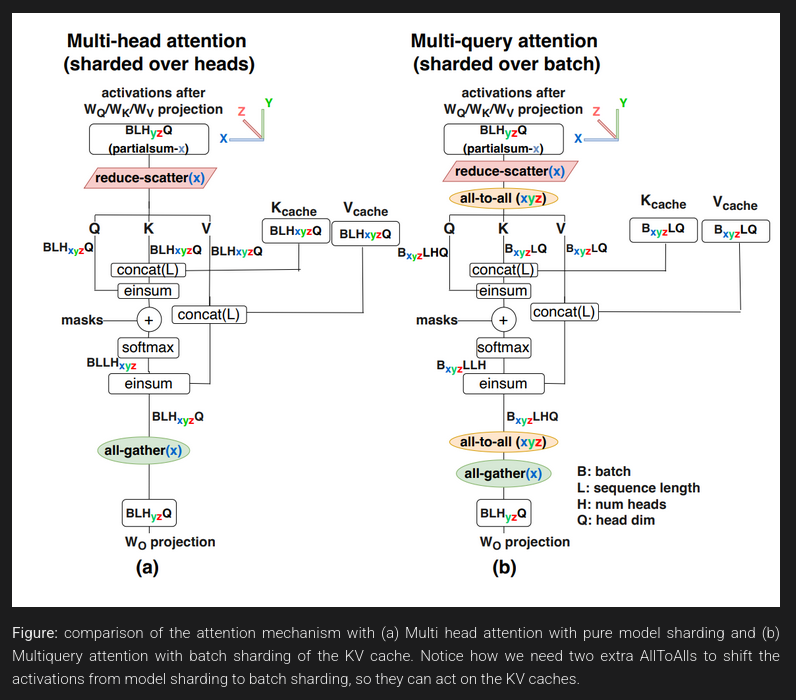

Here's the full algorithm:

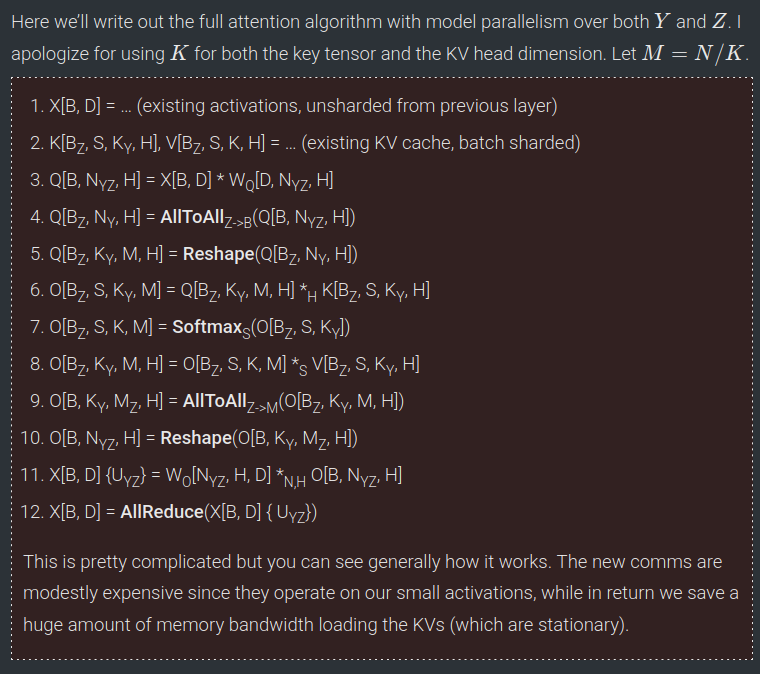

## Designing an Effective Inference Engine

If we want to achieve acceptable MFU and TTFT for prefill and token throughput speed for generation - we must separate decode and prefill. While Transformer inference can be done on one server, it is often better from a latency standpoint to execute the two different tasks on two sets of TPUs/GPUs. Prefill servers generate KV caches that get sent across the network to the generate servers, which batch multiple caches together and generate tokens for each of them. We call this “disaggregated” serving.

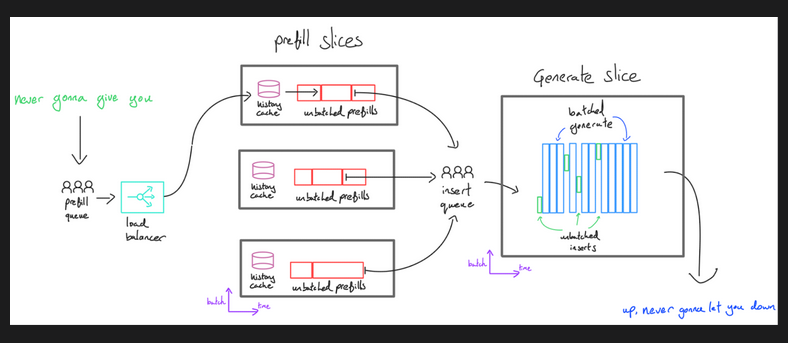

This provides a few advantages:

1. **Low latency at scale**: A user’s request never blocks on another user’s, except if there is insufficient prefill capacity. The request should be immediately prefilled, then sent to the generation server, then immediately slotted into the generation buffer. If we expect many concurrent requests to come in, we can scale the number of prefill servers independently from the number of generate servers so users are not left in the prefill queue for an extended period of time.

2. **Specialization**: Quite often, the latency-optimal parameter sharding strategy/hardware topology for prefill and generate is quite different (for instance, more model parallelism is useful for generate but not prefill). Constraining the two operations to use the same sharding hurts the performance of both, and having two sets of weights uses memory. Also, by moving prefill onto its own server, it doesn’t need to hold any KV caches except the one it’s currently processing. That means we have a lot more memory free for history caching (see the next section) or optimizing prefill latency.

One downside is that the KV cache now needs to be shifted across the network. This is typically acceptable but again provides a motivation for reducing KV cache size.

### Continuous batching

Problem (2) above motivates the concept of continuous batching. We optimize and compile:

- A number of prefill functions with variable context lengths and inserts it into some KV buffer, some maximum batch size and context length/number of pages.
    
- A generate function which takes in the KV cache, and performs the generation step for all currently active requests.

We then combine these functions with an orchestrator which queues the incoming requests, calls prefill and generate depending on the available generate slots, handles history caching (see next section) and streams the tokens out.

In [5]:
from IPython.display import HTML

# Embed GIF using HTML
HTML('<img src="https://jax-ml.github.io/scaling-book/assets/img/continuous-batching.gif" width="800" height="150"/>')

### Prefix caching

Since prefill is expensive and compute-bound (giving us less headroom), one of the best ways to reduce its cost is to do less of it. Because LLMs are autoregressive, the queries [“I”, “like”, “dogs”] and [“I”, “like”, “cats”] produce KV caches that are identical in the first two tokens. What this means is that, in principle, if we compute the “I like dogs” cache first and then the “I like cats” cache, we only need to do 1 / 3 of the compute. We can save most of the work by reusing the cache.

The only reason this is hard to do is memory constraints. As we’ve seen, KV caches are big (often many GB), and for caching to be useful we need to keep them around until a follow-up query arrives. Typically, any unused HBM on the prefill servers can be used for a local caching system. Furthermore, accelerators usually have a lot of memory on their CPU hosts (e.g. a 8xTPUv5e server has 128GiB of HBM, but around 450GiB of Host DRAM). This memory is much slower than HBM — too slow to do generation steps usually — but is fast enough for a cache read. 

In practice:

- Because the KV cache is local to the set of TPUs that handled the initial request, we need some form of affinity routing to ensure follow-up queries arrive at the same replica. This can cause issues with load balancing.

- A smaller KV cache is helpful (again) — it enables us to save more KV caches in the same amount of space, and reduce read times.

- The KV cache and their lookups can be stored quite naturally in a tree or trie. Evictions can happen on an LRU basis.

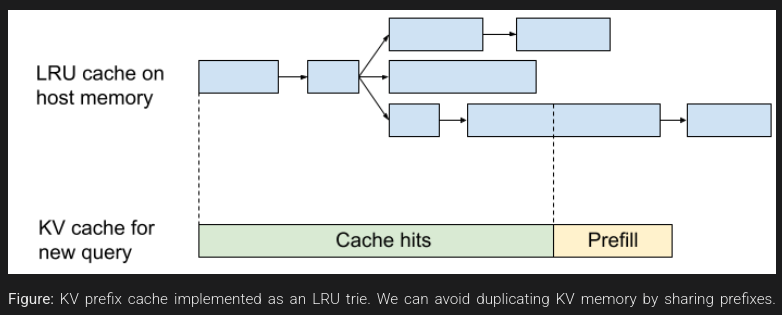